In [3]:
import numpy as np
import pydensecrf.densecrf as dcrf

In [4]:
from skimage.io import imread, imsave

In [5]:
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian

In [67]:
from skimage.color import gray2rgb
import matplotlib.pyplot as plt

In [72]:
"""
Function which returns the labelled image after applying CRF

"""

#Original_image = Image which has to labelled
#Annotated image = Which has been labelled by some technique( FCN in this case)
#Output_image = The final output image after applying CRF
#Use_2d = boolean variable 
#if use_2d = True specialised 2D fucntions will be applied
#else Generic functions will be applied

def crf(original_image, annotated_image,output_image, use_2d = True):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(annotated_image.shape)<3):
        annotated_image = gray2rgb(annotated_image)
    
    imsave("testing2.png",annotated_image)
        
    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = annotated_image[:,:,0] + (annotated_image[:,:,1]<<8) + (annotated_image[:,:,2]<<16)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    
    #Creating a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    
    #Gives no of class labels in the annotated image
    n_labels = len(set(labels.flat)) 
    
    print("No of labels in the Image are ")
    print(n_labels)
    
    
    #Setting up the CRF model
    if use_2d :
        d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

        # get unary potentials (neg log probability)
        U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
        d.setUnaryEnergy(U)

        # This adds the color-independent term, features are the locations only.
        d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

        # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
        d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original_image,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 5 steps 
    Q = d.inference(5)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    # Convert the MAP (labels) back to the corresponding colors and save the image.
    # Note that there is no "unknown" here anymore, no matter what we had at first.
    MAP = colorize[MAP,:]
    imsave(output_image,MAP.reshape(original_image.shape))
    return MAP.reshape(original_image.shape)

    
    



In [73]:
image = imread("original_image2.png")

In [74]:
annotated_image = imread("annotation2.png")

In [75]:
plt.imshow(annotated_image)

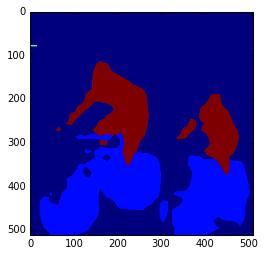

In [76]:
plt.show()

In [77]:
output = crf(image,annotated_image,"testing1.png")

No of labels in the Image are 
4


In [78]:
plt.imshow(output)

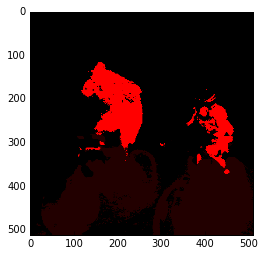

In [79]:
plt.show()

In [65]:
len(annotated_image.shape)

2

In [80]:
image = imread("Aeroplane.png")

In [81]:
annotated_image = imread("Annotation2.png")

In [82]:
plt.imshow(annotated_image)

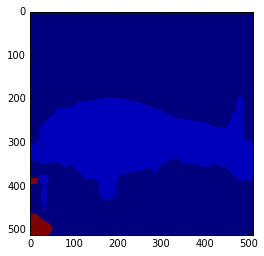

In [83]:
plt.show()

In [84]:
output = crf(image,annotated_image,"testing2.png")

No of labels in the Image are 
3


In [85]:
plt.imshow(output)

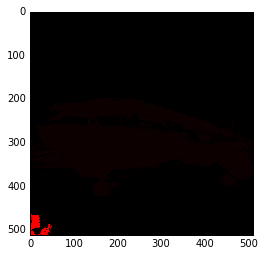

In [86]:
plt.show()